In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:98% !important; }</style>"))

# Additional code so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import cv2
from pprint import pprint
from skimage.color import label2rgb

import degradation_utils as hp

## Import Inputs

In [2]:
# path for image and mask
img_dir = "../damage_ratio_calc_data/damage_ratio_images/"
mask_dir = "../damage_ratio_calc_data/damage_ratio_masks/SegmentationClass/"

filename = "191_jpg.rf.e27c030e763e58ce48964e670158b6e7.jpg"
# filename = "b7db31d1-7ccff061.jpg"

# BEV output size 
bev_transform_shape = (640, 640)

# intensity for good region of marking (0, 255)
good_threshold = 160 

# sample class bins
degradation_bins = [0, 0.25, 0.5, 1]

# class colors
_color_map = {1: (0, 255, 0), 2: (255, 255, 0), 3: (255, 0, 0)}

# roi paramters:
trap_height=340
trap_lower_width=850
trap_corner_offset=320
bottom_offset=0
center_offset=60

In [3]:
# ONLY FOR DEMO
enable_demo = False
if enable_demo:
    config = hp._demo_settings[filename]
    good_threshold = config["threshold"]
    trap_height = config["roi_h"]
    trap_lower_width = config["roi_lw"]
    trap_corner_offset = config["rot_co"]
    bottom_offset = config["roi_bo"]
    center_offset = config["roi_ceo"]

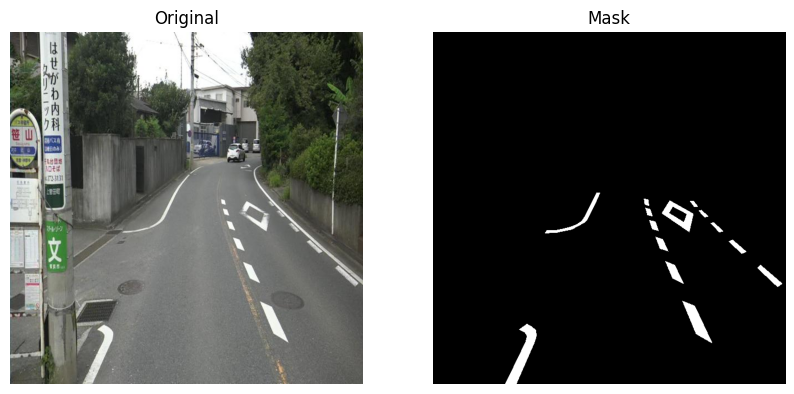

In [4]:
mask_name = ".".join(filename.split(".")[:-1]) + ".png"

img_path = os.path.join(img_dir, filename)
mask_path = os.path.join(mask_dir, mask_name)

img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

mask_img = cv2.imread(mask_path)
mask_img = cv2.cvtColor(mask_img, cv2.COLOR_BGR2RGB)

# convert to binary image
mask_img[mask_img >= 176] = 255
mask_img = cv2.cvtColor(mask_img, cv2.COLOR_RGB2GRAY)
mask_img[mask_img==255] = 1      # ensure mask has only (0,1) values

# visualize inputs
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 10))

ax[0].imshow(img)
ax[0].axis("off")
ax[0].set_title("Original")

ax[1].imshow(mask_img, cmap="gray")
ax[1].axis("off")
ax[1].set_title("Mask")

plt.show()

## Perspective transformation 

In [5]:
# generate ROI coordinates
roi_points = hp.generate_trapezoid_roi(img_shape=img.shape[0:2], trap_height=trap_height, trap_lower_width=trap_lower_width, 
                                       trap_corner_offset=trap_corner_offset, bottom_offset=bottom_offset, center_offset=center_offset)

# get transformation matrix
matrix = hp.generate_perspective_matrix(roi_pts=roi_points, output_shape=bev_transform_shape)

# Apply transformation on both image and mask
img_bev = hp.apply_perspective_transform(img=img.copy(), matrix=matrix, output_shape=bev_transform_shape)
mask_bev = hp.apply_perspective_transform(img=mask_img.copy(), matrix=matrix, output_shape=bev_transform_shape)

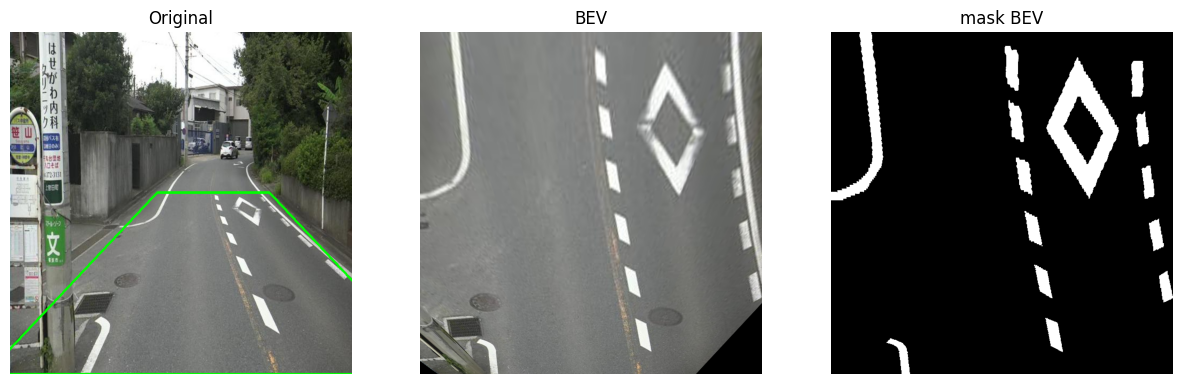

In [6]:
# visualize transformation
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15, 10))

d_points = np.array(roi_points).reshape((-1, 1, 2))
oimg = img.copy()
oimg = cv2.polylines(oimg, [d_points], isClosed=True, color=(0, 255, 0), thickness=3)
ax[0].imshow(oimg)
ax[0].axis("off")
ax[0].set_title("Original")

ax[1].imshow(img_bev)
ax[1].axis("off")
ax[1].set_title("BEV")

ax[2].imshow(mask_bev, cmap="gray")
ax[2].axis("off")
ax[2].set_title("mask BEV")

plt.show()

## BEV Pre-processing

In [7]:
# converting image to grayscale
gray_img_bev = cv2.cvtColor(img_bev, cv2.COLOR_RGB2GRAY)

# perform closing and generate connected components
label_mask, label_count = hp.generate_connected_components(binary_img=mask_bev.copy(), closing=False)

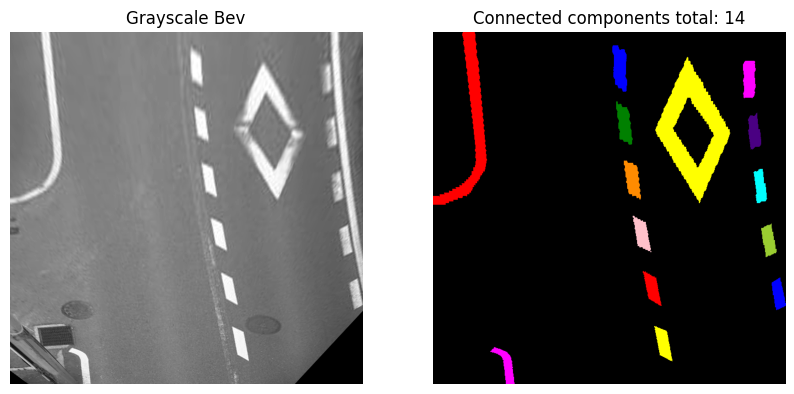

In [8]:
# visualize output
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 10))

ax[0].imshow(gray_img_bev, cmap="gray")
ax[0].axis("off")
ax[0].set_title("Grayscale Bev")

colored_label_mask = label2rgb(label_mask, bg_label=0)
ax[1].imshow(colored_label_mask)
ax[1].axis("off")
ax[1].set_title(f"Connected components total: {label_count}")

plt.show()

## Degradation Ratio Calculations

In [9]:
# list of dict - one for each component with degradation ratio and bbox
degradation_info = hp.cal_component_level_degradation(component_img=label_mask, grayscale_img=gray_img_bev, good_threshold=good_threshold)
# degradation_info

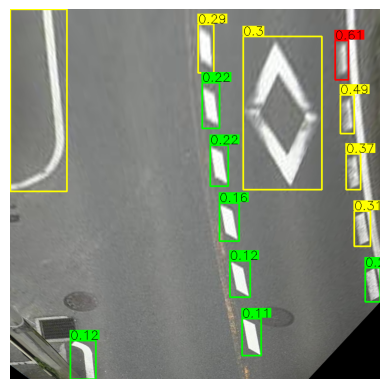

In [10]:
# visualize results
temp = img_bev.copy()
for component in degradation_info:
    
    ratio = component["degradation"]
    bbox = component["bbox"]
    
    b = np.digitize(x=ratio, bins=degradation_bins)
    b = min(b, len(degradation_bins) - 1)   # out of bound values
    color = _color_map[b]
    
    temp = hp.add_bbox(img=temp, bbox=bbox, label=f"{round(ratio, 2)}", bbox_color=color)

plt.imshow(temp)
plt.axis("off")
plt.show()

### Single component degradation regions

Degradation Ratio: 0.3029


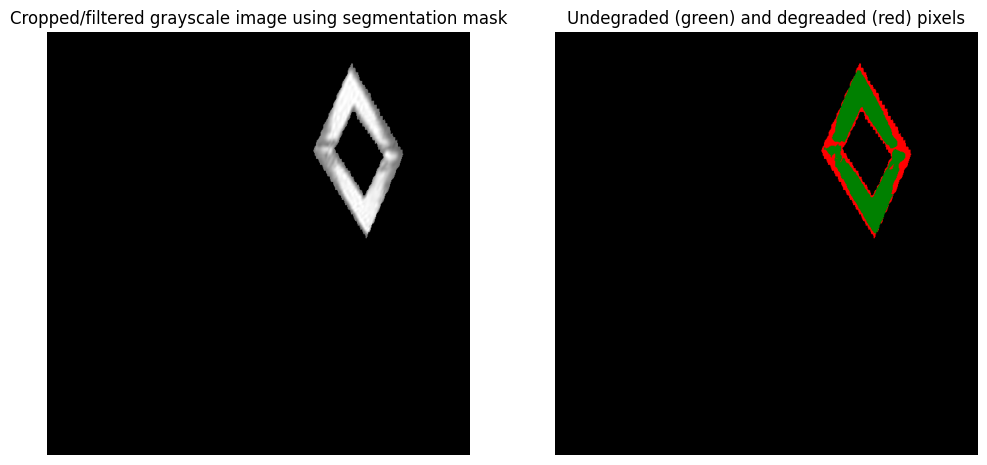

In [11]:
component_idx = 3
component_idx = min(component_idx, label_count)

# filter component
component_mask = (label_mask == component_idx).astype(np.uint8)
total_area = np.sum(component_mask)
component_region = cv2.bitwise_and(gray_img_bev, gray_img_bev, mask=component_mask)  # crop segmented region

undegraded_region = component_region >= good_threshold   # find good intensity pixels
undegraded_area = np.sum(undegraded_region)
degradation_ratio = 1 - (undegraded_area / total_area)
degradation_ratio = round(degradation_ratio, 4)
print("Degradation Ratio:", degradation_ratio)

# visualize results
type_mask = component_mask.copy()  # label the selected good and bad pixels
type_mask[undegraded_region] = 2   # change index of good pixel 

colored_type_mask = label2rgb(type_mask, bg_label=0, colors=["red", "green"])

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 10))
ax[0].imshow(component_region, cmap="gray")
ax[0].axis("off")
ax[0].set_title("Cropped/filtered grayscale image using segmentation mask")

ax[1].imshow(colored_type_mask)
ax[1].axis("off")
ax[1].set_title("Undegraded (green) and degreaded (red) pixels")
plt.show()

## Inverse Transformation with degradation info

In [12]:
# list of dict - one for each component with degradation ratio, axis aligned bbox and object aligned bbox
final_degradation = hp.apply_bbox_inv_perspective_transform(degradation=degradation_info, orig_matrix=matrix)

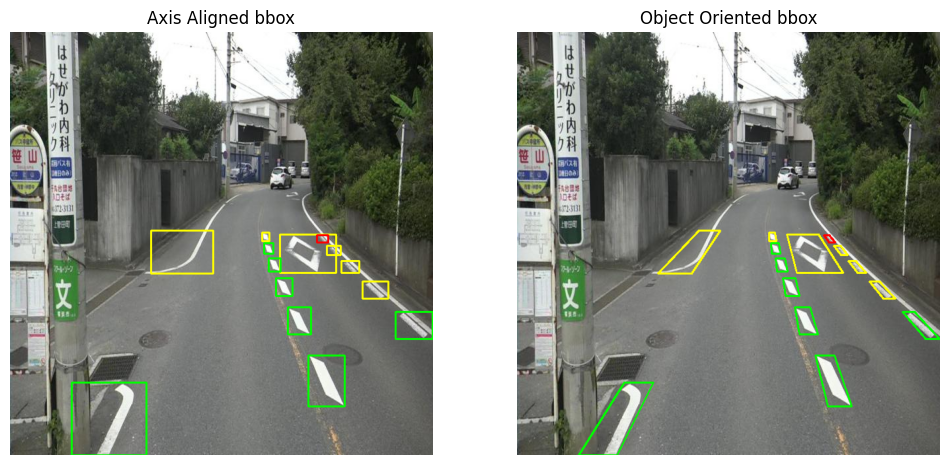

In [13]:
# visualize transformation
abox_temp = img.copy()
obox_temp = img.copy()
for component in final_degradation:
    
    ratio = component["degradation"]
    aa_bbox = component["bbox"]
    o_bbox = component["oriented_bbox"]
    
    b = np.digitize(x=ratio, bins=degradation_bins)
    b = min(b, len(degradation_bins) - 1)   # out of bound values
    color = _color_map[b]
    
    # normal bbox - axis aligned bbox
    abox_temp = hp.add_bbox(img=abox_temp, bbox=aa_bbox, bbox_color=color)
    
    # object oriented bbox
    pts = np.array(o_bbox).reshape(-1, 1, 2)
    obox_temp = cv2.polylines(obox_temp, [pts], isClosed=True, color=color, thickness=2)


fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 10))

ax[0].imshow(abox_temp)
ax[0].axis("off")
ax[0].set_title("Axis Aligned bbox")

ax[1].imshow(obox_temp)
ax[1].axis("off")
ax[1].set_title("Object Oriented bbox")

plt.show()

In [16]:
# plt.figure(figsize=(12,8))
# plt.imshow(img)
# plt.axis("off")
# plt.show()

In [17]:
# plt.figure(figsize=(12,8))
# plt.imshow(abox_temp)
# plt.axis("off")
# plt.show()